In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
pwd

'/content'

In [6]:
os.chdir("/content/drive/My Drive/Hair")
sys.path.append("/content/drive/My Drive/Hair")

In [7]:
pwd

'/content/drive/My Drive/Hair'

In [8]:
# 필요한 라이브러리 설치
!pip install torch==1.11.0+cu102 torchvision==0.12.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
!pip install ftfy regex tqdm matplotlib jupyter ipykernel opencv-python scikit-image kornia==0.6.7 face-alignment==1.3.5 dlib==19.22.1
!pip install git+https://github.com/openai/CLIP.git
!pip install Ninja ipywidgets lpips pyrallis lpips

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached jupyter-1.1.1-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached kornia-0.6.7-py2.py3-none-any.whl.metadata (12 kB)
  Using cached face_alignment-1.3.5-py2.py3-none-any.whl.metadata (6.6 kB)
  Using cached dlib-19.22.1.tar.gz (7.4 MB)
  Preparing metadata (setup.py) ... done
  Using cached jupyterlab-4.3.1-py3-none-any.whl.metadata (16 kB)
  Using cached async_lru-2.0.4-py3-none-any.whl.metadata (4.5 kB)
  Using cached ipykernel-6.29.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached jupyter_lsp-2.2.5-py3-none-any.whl.metadata (1.8 kB)
  Using cached jupyter_server-2.14.2-py3-none-any.whl.metadata (8.4 kB)
  Using cached jupyterlab_server-2.27.3-py3-none-any.whl.metadata (5.9 kB)
  Using cached comm-0.2.2-py3-none-any.whl.metadata (3.7 kB)
  Using cached jupyter_client-7.4.9-py3-none-any.whl.metadata (8.5 kB)
  Using cached jupyter_events-

# **STYLEGAN2 HAIRCLIP**
StyleGAN2 기반으로 HAIRCLIP을 구현한 코드입니다.

In [9]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from scripts.Embedding import Embedding
from scripts.text_proxy import TextProxy
from scripts.bald_proxy import BaldProxy
from scripts.ref_proxy import RefProxy
from scripts.sketch_proxy import SketchProxy
from scripts.color_proxy import ColorProxy
from scripts.feature_blending import hairstyle_feature_blending
from utils.seg_utils import vis_seg
from utils.mask_ui import painting_mask
from utils.image_utils import display_image_list, process_display_input
from utils.model_utils import load_base_models
from utils.options import Options
import warnings
warnings.filterwarnings("ignore")

# **옵션 및 모델 로드**
StyleGAN2 모델과 관련된 옵션과 기본 모델을 로드합니다.

In [10]:
opts = Options().parse(jupyter=True)
src_name1 = 'test.jpg' # @param {"type":"string"}
src_name = src_name1.split('.')[0]
src_pil = Image.open(f'{opts.src_img_dir}/{src_name1}').convert('RGB')

image_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
g_ema, mean_latent_code, seg = load_base_models(opts)
ii2s = Embedding(opts, g_ema, mean_latent_code[0,0])

if not os.path.isfile(os.path.join(opts.src_latent_dir, f"{src_name}.npz")):
    inverted_latent_w_plus, inverted_latent_F = ii2s.invert_image_in_FS(image_path=f'{opts.src_img_dir}/{src_name1}')
    save_latent_path = os.path.join(opts.src_latent_dir, f'{src_name}.npz')
    np.savez(save_latent_path, latent_in=inverted_latent_w_plus.detach().cpu().numpy(),
                latent_F=inverted_latent_F.detach().cpu().numpy())

src_latent = torch.from_numpy(np.load(f'{opts.src_latent_dir}/{src_name}.npz')["latent_in"]).cuda()
src_feature = torch.from_numpy(np.load(f'{opts.src_latent_dir}/{src_name}.npz')["latent_F"]).cuda()
src_image = image_transform(Image.open(f'{opts.src_img_dir}/{src_name1}').convert('RGB')).unsqueeze(0).cuda()
input_mask = torch.argmax(seg(src_image)[1], dim=1).long().clone().detach()

bald_proxy = BaldProxy(g_ema, opts.bald_path)
text_proxy = TextProxy(opts, g_ema, seg, mean_latent_code)
ref_proxy = RefProxy(opts, g_ema, seg, ii2s)
sketch_proxy = SketchProxy(g_ema, mean_latent_code, opts.sketch_path)
color_proxy = ColorProxy(opts, g_ema, seg)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Setting up Perceptual loss...


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Loading model from: /content/drive/MyDrive/Hair/criteria/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 165MiB/s]
Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth


  0%|          | 0.00/85.7M [00:00<?, ?B/s]

Downloading: "https://www.adrianbulat.com/downloads/python-fan/3DFAN4-4a694010b9.zip" to /root/.cache/torch/hub/checkpoints/3DFAN4-4a694010b9.zip


  0%|          | 0.00/91.9M [00:00<?, ?B/s]

Downloading: "https://www.adrianbulat.com/downloads/python-fan/depth-6c4283c0e0.zip" to /root/.cache/torch/hub/checkpoints/depth-6c4283c0e0.zip


  0%|          | 0.00/224M [00:00<?, ?B/s]

Setting up Perceptual loss...
Loading model from: /content/drive/MyDrive/Hair/criteria/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


# **헤어스타일 편집 함수 정의**

In [11]:
def hairstyle_editing(global_cond=None, local_sketch=False, paint_the_mask=False, \
                      src_latent=src_latent, src_feature=src_feature, input_mask=input_mask, src_image=src_image, \
                        latent_global=None, latent_local=None, latent_bald=None, local_blending_mask=None, painted_mask=None):
    if paint_the_mask:
        modified_mask = painting_mask(input_mask)
        input_mask = torch.from_numpy(modified_mask).unsqueeze(0).cuda().long().clone().detach()
        vis_modified_mask = vis_seg(modified_mask)
        display_image_list([src_image, vis_modified_mask])
        painted_mask = input_mask

    if local_sketch:
        latent_local, local_blending_mask, visual_local_list = sketch_proxy(input_mask)
        display_image_list(visual_local_list)

    if global_cond is not None:
        assert isinstance(global_cond, str)
        latent_bald, visual_bald_list = bald_proxy(src_latent)
        display_image_list(visual_bald_list)

        if global_cond.endswith('.jpg') or global_cond.endswith('.png'):
            latent_global, visual_global_list = ref_proxy(global_cond, src_image, painted_mask=painted_mask)
        else:
            latent_global, visual_global_list = text_proxy(global_cond, src_image, from_mean=True, painted_mask=painted_mask)
        display_image_list(visual_global_list)

    src_feature, edited_hairstyle_img = hairstyle_feature_blending(g_ema, seg, src_latent, src_feature, input_mask, latent_bald=latent_bald,\
                                                latent_global=latent_global, latent_local=latent_local, local_blending_mask=local_blending_mask)
    return src_feature, edited_hairstyle_img


# **결과 시각화**
헤어스타일 편집

In [12]:
global_cond='168125.jpg'# @param {"type":"string"}
src_feature, edited_hairstyle_img = hairstyle_editing(global_cond=global_cond, local_sketch=False, paint_the_mask=False)

Output hidden; open in https://colab.research.google.com to view.

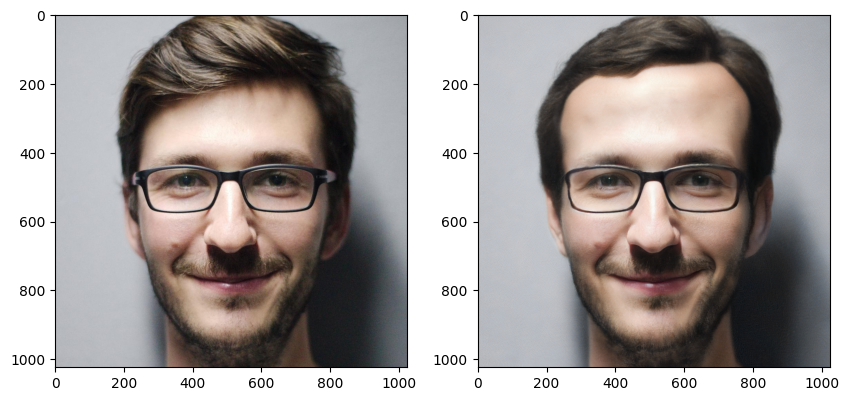

In [13]:
display_image_list([process_display_input(src_image), process_display_input(edited_hairstyle_img)])

염색

In [14]:
color_cond = '108157.jpg'# @param {"type":"string"}

visual_color_list, visual_final_list = color_proxy(color_cond, edited_hairstyle_img, src_latent, src_feature)
display_image_list(visual_color_list)
display_image_list(visual_final_list)

Output hidden; open in https://colab.research.google.com to view.

In [15]:
# 출력 이미지 저장
img_output = Image.fromarray(np.array(process_display_input(visual_final_list[-1])).astype(np.uint8))
im_path = os.path.join("/content/drive/My Drive/Hair/output_image", f'{src_name1}_{global_cond.split(".")[0]}_{color_cond.split(".")[0]}_sg2.jpg')
img_output.save(im_path)
print(f'Done saving output {src_name1}_{global_cond.split(".")[0]}_{color_cond.split(".")[0]}_sg2.jpg')

Done saving output test.jpg_168125_108157_sg2.jpg


# **STYLEGAN3 HAIRCLIP**
StyleGAN3 기반으로 HAIRCLIP을 구현한 코드입니다.


In [16]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from scripts.Embedding import Embedding_sg3
from scripts.ref_proxy import RefProxy_sg3
from scripts.feature_blending import hairstyle_feature_blending_sg3, hairstyle_feature_blending33
from scripts.refine_image import RefineProxy
from scripts.color_proxy import ColorProxy_sg3
from scripts.bald_proxy import BaldProxy_sg3
from editing.interfacegan.face_editor import FaceEditor
from models.stylegan3.model import GeneratorType
from utils.image_utils import display_image_list, process_display_input
from utils.model_utils import load_sg3_models
from utils.options import Options
from criteria.embedding_loss import EmbeddingLossBuilder
from skimage.metrics import structural_similarity as ssim
import warnings
warnings.filterwarnings("ignore")

# **옵션 및 모델 로드**
StyleGAN3 모델과 관련된 옵션과 기본 모델을 로드합니다.

In [17]:
opts = Options().parse(jupyter=True)
opts.W_steps = 500
opts.steps_ref = 200
opts.steps_refine = 400

# 모델 로드
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

generator, opts_sg3, seg, avg_img = load_sg3_models(opts)

# 임베딩 및 손실 함수
re4e = Embedding_sg3(opts, generator)
loss_builder = EmbeddingLossBuilder(opts)

# 편집 도구 로드
ref_proxy = RefProxy_sg3(opts, generator, seg, re4e)
refine_proxy = RefineProxy(opts, generator, seg)
color_proxy = ColorProxy_sg3(opts, generator, seg)
bald_proxy = BaldProxy_sg3(generator, opts.bald_path)
# InterfaceGAN 초기화
editor = FaceEditor(stylegan_generator=generator.decoder, generator_type=GeneratorType.ALIGNED)
edit_direction = ['Bald', 'pose']

Loading ReStyle e4e from checkpoint: /content/drive/My Drive/Hair/pretrained_models/restyle_e4e_ffhq.pt
Loading StyleGAN3 generator from path: None
Done!
Model successfully loaded!
Updating SG3 generator with generator from path: /content/drive/My Drive/Hair/pretrained_models/sg3-r-ffhq-1024.pt
Loading StyleGAN3 generator from path: /content/drive/My Drive/Hair/pretrained_models/sg3-r-ffhq-1024.pt
Done!
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
Setting up Perceptual loss...
Loading model from: /content/drive/MyDrive/Hair/criteria/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done
Setting up Perceptual loss...
Loading model from: /content/drive/MyDrive/Hair/criteria/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done
Setting up Perceptual loss...
Loading model from: /content/drive/MyDrive/Hair/criteria/masked_lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done
Setting up Perceptual loss...
Loading model from: /content/drive/MyD

# **결과 시각화**
헤어스타일 편집

Performing edit for Bald...


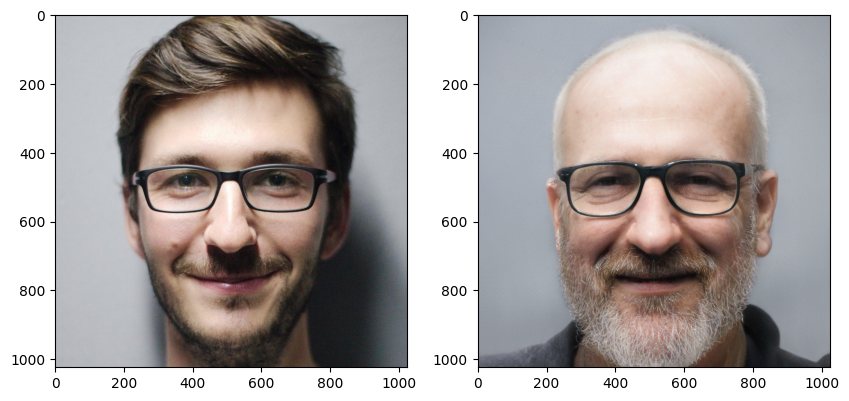

In [18]:
# @title 결과 시각화
src_name = "test.jpg" # @param {"type":"string"}

if not os.path.isfile(os.path.join(opts.ref_latent_dir, f"{src_name.split('.')[0]}_sg3.npy")):
    src_latent = re4e.invert_image_in_W(image_path=os.path.join(opts.src_img_dir,f'{src_name}'), device='cuda', avg_image=avg_img)
else:
    src_latent = torch.from_numpy(np.load(f'{opts.ref_latent_dir}/{src_name.split(".")[0]}_sg3.npy')).cuda()
src_pil = Image.open(f'{opts.src_img_dir}/{src_name}').convert('RGB')
src_image = image_transform(src_pil).unsqueeze(0).cuda()
input_mask = torch.argmax(seg(src_image)[1], dim=1).long().clone().detach()


print(f"Performing edit for {edit_direction[0]}...")
bald_feat, edit_latents = editor.edit(src_image,
                            latents=src_latent,
                            direction=edit_direction[0],
                            factor = 5,
                            user_transforms=None,
                            apply_user_transformations=False)
latent_bald=edit_latents[-1].unsqueeze(0)
display_image_list([src_image,bald_feat])

In [23]:
# @title Ref Proxy
target_name = "168125.jpg" # @param {"type":"string"}

#Embed target image
if not os.path.isfile(os.path.join(opts.ref_latent_dir, f"{target_name.split('.')[0]}_sg3.npy")):
  ref_latent = re4e.invert_image_in_W(image_path=os.path.join(opts.src_img_dir,f'{target_name}'), device='cuda', avg_image=avg_img)
else:
  ref_latent = torch.from_numpy(np.load(f'{opts.ref_latent_dir}/{target_name.split(".")[0]}_sg3.npy')).cuda()

#Pose editing on target image to follow source pose
print(f"Performing edit for {edit_direction[1]}...")
pose_edited_latent=None
ref_feat, edit_latents = editor.edit(src_image,
                  latents=ref_latent,
                  direction=edit_direction[1],
                  factor_range = (-5,5),
                  user_transforms=None,
                  apply_user_transformations=False)
if edit_latents is not None:
    pose_edited_latent = edit_latents[-1]

#Align target
latent_global,visual_global_list=ref_proxy(target_name, src_image=src_image, m_style=5,edit_latent=pose_edited_latent)

Performing edit for pose...
Initial keypoint difference: 0.0032607668545097113
Perform ref proxy on initial ref image...


ref_loss: 0.0589;: 100%|██████████| 200/200 [02:35<00:00,  1.28it/s]


In [ ]:
blend_source, _, edited_latent = hairstyle_feature_blending_sg3(generator, seg, src_image, input_mask, latent_bald, latent_global, avg_img)

target_mask = seg(blend_source)[1]
final_image,blended_latent, visual_list = refine_proxy(blended_latent=edited_latent, src_image=src_image, ref_img=visual_global_list[-1],target_mask=target_mask)
display_image_list([src_image,final_image])

refine_loss: 0.3358;:  34%|███▍      | 138/400 [01:34<02:55,  1.50it/s]

염색

In [ ]:
color_cond = '108157.jpg'# @param {"type":"string"}

visual_final_list = color_proxy(color_cond, final_image, blended_latent, blend_source)
display_image_list(visual_final_list)
display_image_list([src_image, visual_final_list[-1]])
final_image2 = visual_final_list[-1]

In [ ]:
img_output = Image.fromarray(np.array(process_display_input(final_image2)).astype(np.uint8))
im_path = os.path.join("/content/drive/My Drive/Hair/output_image", f'{src_name.split(".")[0]}_{target_name.split(".")[0]}_{color_cond.split(".")[0]}_sg3.jpg')
img_output.save(im_path)

# **평가 지표**
1. LPIPS (Learned Perceptual Image Patch Similarity)
: 심층 신경망을 활용해 지각적 유사도를 측정하며, 값이 작을수록 유사함.
2. SSIM (Structural Similarity Index Measure)
 : 밝기, 명암비, 구조를 고려한 구조적 유사성 측정. 값이 1에 가까울수록 유사함.
3. PSNR (Peak Signal-to-Noise Ratio)
 : 이미지 간 신호 대 잡음 비를 데시벨 단위로 측정하며, 값이 클수록 품질이 우수함.
4. Mean Phase Error (MPE)
 : 주파수 도메인에서 위상 차이를 측정하며, 값이 작을수록 위상 보존이 우수함.
5. Edge Sharpness
 : 경계선의 선명도를 측정하며, 값이 클수록 이미지의 경계선이 더 뚜렷함.
6. Texture Analysis (GLCM)
 : Gray Level Co-occurrence Matrix를 기반으로 텍스처의 대조(contrast)와 상관성(correlation)을 분석.
<br> => Contrast: 높을수록 텍스처가 복잡하거나 거칠음.
Correlation: 높을수록 텍스처 패턴이 규칙적이고 일관성이 있음

In [ ]:
import cv2
import numpy as np
import lpips
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.feature import graycomatrix, graycoprops

# 얼굴 탐지 및 얼굴 영역 추출
def detect_face_and_crop(image, face_detector):
    faces = face_detector.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5)
    if len(faces) > 0:
        x, y, w, h = faces[0]  # 첫 번째 얼굴만 사용
        return image[y:y+h, x:x+w]
    return None

# LPIPS 계산
def calculate_lpips(image1, image2, lpips_model):
    target_size = (256, 256)  # 크기 충분히 크게 설정
    image1_resized = cv2.resize(image1, target_size)
    image2_resized = cv2.resize(image2, target_size)

    # LPIPS 모델에 입력 (텐서 변환)
    image1_tensor = lpips.im2tensor(image1_resized)
    image2_tensor = lpips.im2tensor(image2_resized)
    return lpips_model(image1_tensor, image2_tensor)

def calculate_phase_difference(img1, img2):
    """
    두 이미지 간 위상 차이를 계산합니다.
    """
    # 푸리에 변환
    f1 = np.fft.fft2(img1)
    f2 = np.fft.fft2(img2)

    # 위상 정보 추출
    phase1 = np.angle(f1)
    phase2 = np.angle(f2)

    # 위상 차이 계산
    phase_diff = np.abs(phase1 - phase2)

    # 평균 위상 차이 반환
    mean_phase_error = np.mean(phase_diff)
    return mean_phase_error

def edge_sharpness(img):
    """
    Canny Edge Detection으로 경계선 추출 및 날카로움 측정.
    """
    edges = cv2.Canny(img, 100, 200)
    edge_intensity = np.sum(edges) / edges.size  # 경계선 픽셀의 비율 계산
    return edge_intensity

def texture_analysis(img):
    """
    Gray Level Co-occurrence Matrix (GLCM) 기반 텍스처 분석.
    """
    # 이미지를 회색조로 변환 (필요 시)
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # GLCM 계산
    glcm = graycomatrix(img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return contrast, correlation

original_img = 'test.jpg'# @param {"type":"string"}
generate_img_sg2 = 'test_168125_108157_sg2.jpg'# @param {"type":"string"}
generate_img_sg3 = 'test_168125_108157_sg3.jpg'# @param {"type":"string"}
img_name_path1 = os.path.join("/content/drive/My Drive/Hair/test_images/src_img",original_img)
img_name_path2 = os.path.join("/content/drive/My Drive/Hair/output_image",generate_img_sg2)
img_name_path3 = os.path.join("/content/drive/My Drive/Hair/output_image",generate_img_sg3)
image1 = cv2.imread(img_name_path1)
image2 = cv2.imread(img_name_path2)
image3 = cv2.imread(img_name_path3)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

face1 = detect_face_and_crop(image1, face_cascade)
face2 = detect_face_and_crop(image2, face_cascade)
face3 = detect_face_and_crop(image3, face_cascade)

if face1 is not None and face2 is not None and face3 is not None:
    # LPIPS 모델 로드
    lpips_model = lpips.LPIPS(net='alex')  # LPIPS 모델 (AlexNet 또는 VGG)

    # LPIPS
    lpips_score_sg2 = calculate_lpips(face1, face2, lpips_model)
    lpips_score_sg3 = calculate_lpips(face1, face3, lpips_model)
    print("LPIPS: SG2", lpips_score_sg2.item(), "SG3",lpips_score_sg3.item())

    # SSIM
    face1_resized = cv2.resize(face1, (256, 256))
    face2_resized = cv2.resize(face2, (256, 256))
    face3_resized = cv2.resize(face3, (256, 256))

    min_dim = min(face1_resized.shape[0], face1_resized.shape[1])
    win_size = min(7, min_dim)  # 7 또는 이미지의 최소 크기 중 작은 값 선택

    ssim_score_sg2 = ssim(face1_resized, face2_resized, channel_axis=-1, win_size=win_size)
    ssim_score_sg3 = ssim(face1_resized, face3_resized, channel_axis=-1, win_size=win_size)
    print("SSIM: SG2", ssim_score_sg2,"SG3",ssim_score_sg3)

    # PSNR
    psnr_score_sg2 = psnr(face1_resized, face2_resized)
    psnr_score_sg3 = psnr(face1_resized, face3_resized)
    print("PSNR: SG2", psnr_score_sg2,"SG3", psnr_score_sg3)

    # 위상 차이 계산
    phase_diff_sg2 = calculate_phase_difference(face1_resized, face2_resized)
    phase_diff_sg3 = calculate_phase_difference(face1_resized, face3_resized)
    print(f"Mean Phase Difference: SG2 {phase_diff_sg2} SG3 {phase_diff_sg3}")

    # Edge Sharpness
    edge_sg2 = edge_sharpness(face2_resized)
    edge_sg3 = edge_sharpness(face3_resized)

    print(f"Edge Sharpness: SG2 {edge_sg2} SG3 {edge_sg3}")

    # 텍스처 비교
    contrast_sg2, corr_sg2 = texture_analysis(face2_resized)
    contrast_sg3, corr_sg3 = texture_analysis(face3_resized)

    print(f"Texture - SG2: Contrast={contrast_sg2}, Correlation={corr_sg2}")
    print(f"Texture - SG3: Contrast={contrast_sg3}, Correlation={corr_sg3}")
else:
    print("얼굴 탐지 실패")

